In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt

Функции операторов  
- принимают параметры сетки и размерность задачи
- возвращают двумерный numpy массив

In [77]:
def second_derivative_operator(size, dx):
  matrix = np.eye(size)
  i,j=np.indices(matrix.shape)
  matrix[i==j]=-2
  matrix[i==j-1]=1
  matrix[i==j+1]=1
  matrix[0][size-1]=1
  matrix[size-1][0]=1
  matrix=matrix/dx/dx
  return matrix

In [78]:
def full_operator(size, dt, dx, g, H):
  return np.eye(size)-g*H*dt*dt*second_derivative_operator(size,dx)

Функции методов,
- принимают начальную точку, матрицу, правую часть и число итераций
- возвращают numpy массив err_log, в котором на i-м месте лежат два-нормы ошибки на i-м шаге алгоритма

In [178]:
def sg_method(start_point, matrix, right_part, iter_number, er=1E-16):
  size = len(start_point)
  assert np.shape(matrix)[0] == size
  assert np.shape(matrix)[0] == np.shape(matrix)[1]
  assert len(right_part) == size

  real_answer = np.linalg.inv(matrix)@right_part

  err_log = np.zeros(iter_number)
  A=matrix
  b=right_part
  x=start_point
  r=b-A@x
  p=r

  for i in range(iter_number):
    Ap=A@p
    alpha=(r@r)/((Ap)@p)
    xnew=x+alpha*p
    rnew=r-alpha*Ap
    beta=(rnew@rnew)/(r@r)
    p=rnew+beta*p
    r=rnew

 #   if(r@r<er):
 #     break
    err_log[i]=np.linalg.norm(xnew-x,2)
    x=xnew

  return err_log

In [188]:
range(2)

range(0, 2)

In [239]:
from math import sqrt
#q=(\sqrt(mu)-1)/(\sqrt(mu)+1) - скорость сходимости метода, lag - число итераций после которых начинается теор построение
#если строить с первой то есть риск нарвать на артефакты
def sg_theoretical_method(start_point, matrix, right_part, iter_number, mu, lag = 4):
  real_answer = np.linalg.inv(matrix)@right_part
  assert np.shape(matrix)[0] == size
  assert np.shape(matrix)[0] == np.shape(matrix)[1]
  assert len(right_part) == size
  q = (sqrt(mu)-1)/(sqrt(mu)+1)
  print("sg_theor q = {}".format(q))
  err_log = np.zeros(iter_number)

  #Сделаем пару настоящих итераций чтобы выцепить ||x_{k+1}-x_{k}|| и затем продолжить его
  A=matrix
  b=right_part
  x=start_point
  r=b-A@x
  p=r

  for i in range(lag):
    Ap=A@p
    alpha=(r@r)/((Ap)@p)
    xnew=x+alpha*p
    rnew=r-alpha*Ap
    beta=(rnew@rnew)/(r@r)
    p=rnew+beta*p
    r=rnew
    err_log[i]=np.linalg.norm(xnew-x,2)
    x=xnew


  for i in range(lag,iter_number):
    err_log[i]=q*err_log[i-1]

  return err_log


In [240]:
def jacobi_method(start_point, matrix, right_part, iter_number):
  size = len(start_point)
  assert np.shape(matrix)[0] == size
  assert np.shape(matrix)[0] == np.shape(matrix)[1]
  assert len(right_part) == size

  real_answer = np.linalg.inv(matrix)@right_part

  err_log = np.zeros(iter_number)

  D    = matrix*np.eye(size)
  LpU  = matrix-D

  Dinv=D
  i,j=np.indices(Dinv.shape)
  Dinv[i==j]=1/Dinv[i==j]

  x=start_point

  for i in range(iter_number):
    xnew=(right_part-(LpU)@x)@Dinv
    err_log[i]=np.linalg.norm(xnew-x,2)
    x=xnew

  return err_log

In [241]:
def jacobi_theor_method(start_point, matrix, right_part, iter_number):
  real_answer = np.linalg.inv(matrix)@right_part
  assert np.shape(matrix)[0] == size
  assert np.shape(matrix)[0] == np.shape(matrix)[1]
  assert len(right_part) == size
  err_log = np.zeros(iter_number)

  #Сделаем одну настоящую итерацию чтобы узнать ||x_1-x_0||
  D    = matrix*np.eye(size)
  LpU  = matrix-D

  Dinv=D
  i,j=np.indices(Dinv.shape)
  Dinv[i==j]=1/Dinv[i==j]

  q=np.linalg.norm(Dinv@LpU,2)
  print("jacob_theor q={}".format(q)) #q узнаем напрямую посчитав норму, оценки которые у меня получилась на эксперименте оказались слишком грубыми
  x=start_point

  xnew=(right_part-(LpU)@x)@Dinv
  err_log[0]=np.linalg.norm(xnew-x,2)

  for i in range(1,iter_number):
    err_log[i]=q*err_log[i-1]

  return err_log

Функция отрисовки логов
- принимает в себя массив логов одинакового размера, имена для легенды, стили для отрисовки, параметры сетки, флаг для записи в директорию, флаг для логарифмирования, начальную и конечную точки сетки
- рисует пнг файл со сходимостями в директории

In [242]:
def logs_draw(logs, labels,styles, dt, dx, method_step, write_flag, log_flag, start, end):
  for i in range(len(logs)):
    log=logs[i]
 #   mean_speed = np.mean(log[:-1]/log[1:])
    plt.plot(range(len(log[start:end])), log[start:end], label=labels[i],linestyle=styles[i])

  plt.title("dt = " + str(dt) + " dx = " + str(dx))
  plt.xlabel("iteration number")
  if(log_flag == 0):
    plt.ylabel(r"$||x_{k+1}-x_{k}||^2$")
  if(log_flag == 1):
    plt.ylabel(r"$\log||x_{k+1}-x_{k}||^2$")
    plt.yscale('log')


  #getting time
  from datetime import datetime
  now = datetime.now()
  current_time = now.strftime("%H:%M:%S")

  plt.legend()
  if (write_flag == 1):
    filename = "comparison test " + str(current_time)+" dt = " + str(dt) + " dx = " + str(dx) + "step = " + str(method_step)+".png"
    plt.savefig(filename)

Функция основного теста :
- Вход это размер матрицы,шаг по времени, шаг по пространству, шаг по времени, шаг итерационного процесса, количество итераций, начальную точку, флаги для отрисовки, диапазоны отрисовки
- На выходе рисует (в директорию если поднят соответствующий флаг) картинки сходимости

In [243]:
size = 100

In [234]:
def methods_test(method_step, start_point, right_part, size=100, dt=1, dx=100, iter_number = 1000, write_flag = 0, log_flag = 0, start=0, end = 1000, g=10, H=1000 ):
  matrix = full_operator(size,dt,dx,g,H)
  mu = (1+4*g*H*dt*dt/dx/dx) # Число обусловленности
  print("mu ={}".format(mu))
  sg_log = sg_method(start_point, matrix, right_part, iter_number)
  sg_theor_log = sg_theoretical_method(start_point, matrix, right_part, iter_number, mu)
  jacobi_log = jacobi_method(start_point, matrix,right_part, iter_number)
  jacobi_theor_log = jacobi_theor_method(start_point, matrix, right_part, iter_number)
  labels=["conjudate","conjudate_theor","jacobi","jacobi_theor"]
  styles=["-","-.","-","-."]
  logs = [sg_log,sg_theor_log, jacobi_log, jacobi_theor_log]
  logs_draw(logs, labels,styles, dt, dx, method_step, write_flag, log_flag, start, end)

mu =101.0
sg_theor q = 0.8190024875775822
jacob_theor q=0.9090909090909092


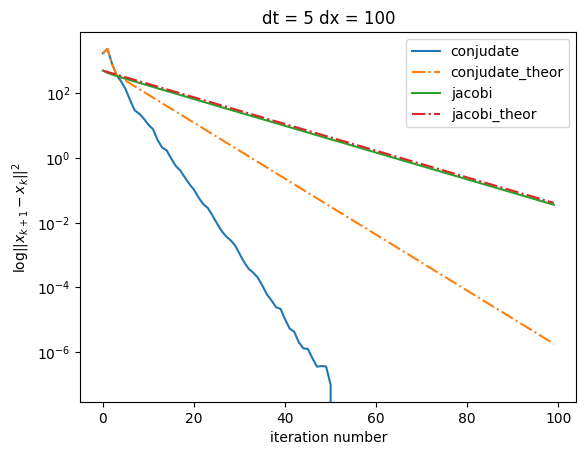

In [244]:
methods_test(method_step = 1, start_point = np.zeros(size), dt = 5, right_part = np.random.uniform(0.5, 1000, size), iter_number=100,write_flag = 0, log_flag = 1, end = 100, size = size)

mu =26.0
sg_theor q = 0.6720784389125772
jacob_theor q=0.8333333333333334


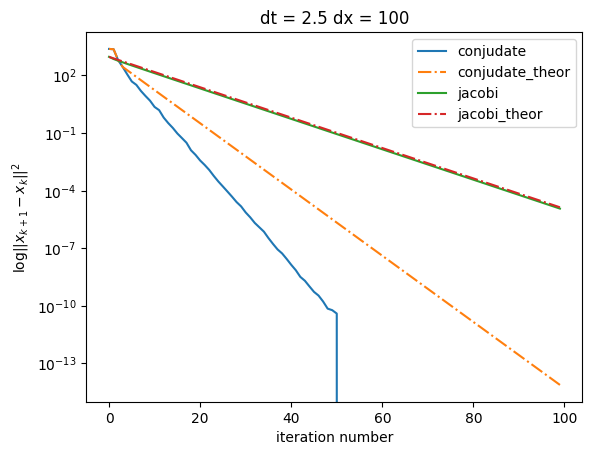

In [245]:
methods_test(method_step = 1, start_point = np.zeros(size), dt = 2.5, right_part = np.random.uniform(0.5, 1000, size), iter_number=100,write_flag = 0, log_flag = 1, end = 100, size = size)

mu =5.0
sg_theor q = 0.38196601125010515
jacob_theor q=0.6666666666666665


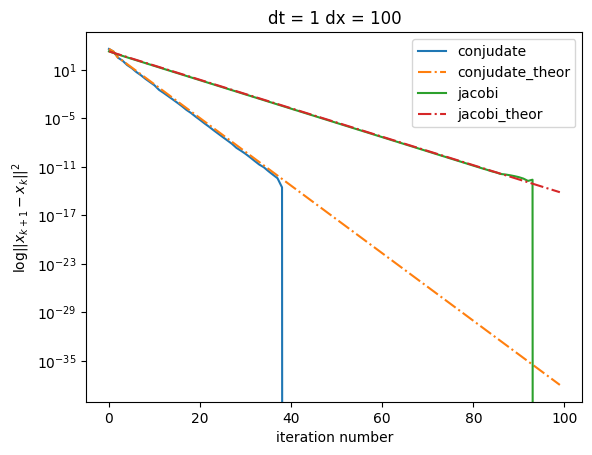

In [246]:
methods_test(method_step = 1, start_point = np.zeros(size), right_part = np.random.uniform(0.1, 1000, size), iter_number=100,write_flag = 0, log_flag = 1, end = 100, size = size)

mu =2.0
sg_theor q = 0.17157287525380996
jacob_theor q=0.5


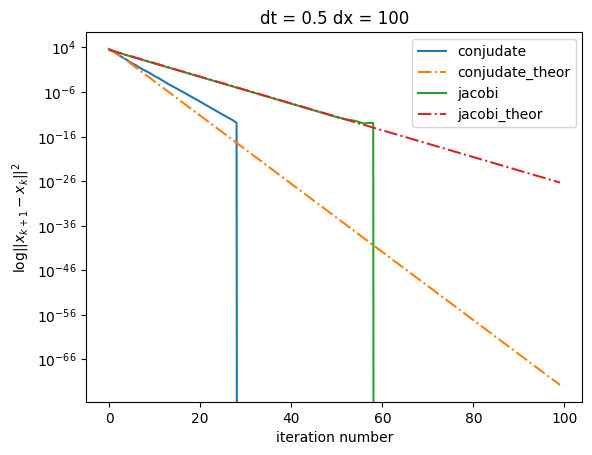

In [248]:
methods_test(method_step = 1, start_point = np.zeros(size), dt = 0.5, right_part = np.random.uniform(0.5, 1000, size), iter_number=100,write_flag = 0, log_flag = 1, end = 100, size = size)

mu =1.04
sg_theor q = 0.00980486407215173
jacob_theor q=0.16666666666666666


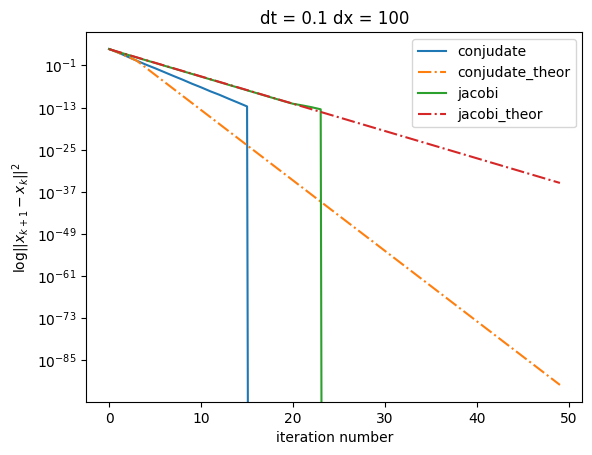

In [250]:
methods_test(method_step = 1, start_point = np.zeros(size),dt=0.1, right_part = np.random.uniform(0.1, 1000, size), iter_number=50,write_flag = 0, log_flag = 1, end = 50, size = size)